In [1]:
import os

In [ ]:
%pip install equinox optax matplotlib
%pip install torch torch_geometric

In [15]:
from functools import partial
from typing import Sequence

import jax
import jax.numpy as jnp
import equinox as eqx
import numpy as np
import optax

import torch
from torch_geometric.datasets import MD17
from torch_geometric.data import Data
from torch_geometric.transforms import NormalizeScale, Center, BaseTransform
from torch_geometric.loader import DataLoader, DenseDataLoader

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Geometry import Point3D

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [6.0, 4.0]



In [6]:
class RecomputePosBasedOnCenter(BaseTransform):
    def __call__(self, data: Data) -> Data:
        pos = data.pos
        
        # Calculate the center of each node
        center = pos.mean(dim=0, keepdim=True)
        
        # Recompute positions based on the center
        data.pos = pos - center
        
        return data

In [7]:
dataset = MD17(root='./dataset', name='revised benzene', transform=RecomputePosBasedOnCenter())
loader = DenseDataLoader(dataset, batch_size=256, shuffle=True)

Extracting dataset/raw/file
Processing...
Done!
/rds/general/user/wc5118/home/anaconda3/envs/jax_env/lib/python3.11/site-packages/torch_geometric/io/fs.py:215: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

In [8]:
batch = next(iter(loader))
x = batch.pos


In [42]:
def calculate_bond_lengths_batched(positions):
    # Get the pairwise distances between all atoms in each batch using torch.cdist
    # positions is of shape (batch_size, num_atoms, 3)
    carbon_indices = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0]], dtype=torch.long)

    bond_lengths = torch.cdist(positions, positions)  # shape: (batch_size, num_atoms, num_atoms)
    
    # Extract the bond lengths for consecutive carbon atoms (C1-C2, C2-C3, ..., C6-C1)
    # Benzene has 6 carbon atoms (indices 0-5). Bond pairs are [(0,1), (1,2), ..., (5,0)].
    
    # Gather bond lengths between the consecutive carbon atoms
    bond_lengths = bond_lengths[:, carbon_indices[:, 0], carbon_indices[:, 1]]  # shape: (batch_size, 6)
    
    return bond_lengths

def calculate_bond_angles_batched(positions):
    # Benzene has 6 carbon atoms, so the bond angles will be calculated between sets of 3 consecutive carbon atoms
    # Indices for the consecutive carbon atoms (C1-C2-C3, C2-C3-C4, ..., C6-C1-C2)
    carbon_indices = torch.tensor([[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5], [4, 5, 0], [5, 0, 1]], dtype=torch.long)
    
    
    vec1 = positions[:, carbon_indices[:, 0]] - positions[:, carbon_indices[:, 1]]  # Vector between atom i and j
    vec2 = positions[:, carbon_indices[:, 2] % 6] - positions[:, carbon_indices[:, 1]]  # Vector between atom j and k

    # Normalize the vectors to unit vectors
    vec1_norm = vec1 / vec1.norm(dim=-1, keepdim=True)
    vec2_norm = vec2 / vec2.norm(dim=-1, keepdim=True)
    
    # Calculate the cosine of the angles
    cos_theta = (vec1_norm * vec2_norm).sum(dim=-1)  # Dot product along last axis
    
    # Convert to bond angles in degrees
    angles = torch.acos(torch.clamp(cos_theta, -1.0, 1.0))  # Keep within valid range of acos
    angles = torch.rad2deg(angles)  # Convert from radians to degrees
    
    return angles

def calculate_out_of_plane_distortion(positions):
    # Benzene has 6 carbon atoms. We will calculate the out-of-plane distortion for each carbon atom
    # by using its neighboring three atoms to define the plane.
    carbon_indices = torch.tensor([[0, 1, 2, 3], [1, 2, 3, 4], [2, 3, 4, 5], 
                                   [3, 4, 5, 0], [4, 5, 0, 1], [5, 0, 1, 2]], dtype=torch.long)

    out_of_plane_distortions = []
    
    for i in range(6):  # Loop over each carbon atom
        # Get the positions of the atoms that define the plane (using atoms j, k, l)
        j, k, l = carbon_indices[i][1], carbon_indices[i][2], carbon_indices[i][3]
        
        # Calculate vectors lying in the plane
        v1 = positions[:, k] - positions[:, j]  # Vector from atom j to atom k
        v2 = positions[:, l] - positions[:, j]  # Vector from atom j to atom l
        
        # Calculate the normal vector to the plane using the cross product
        normal_vector = torch.cross(v1, v2, dim=-1)  # Cross product gives normal to the plane
        
        # Normalize the normal vector
        normal_vector /= normal_vector.norm(dim=-1, keepdim=True)
        
        # Calculate the vector from atom i (the central atom) to one of the atoms defining the plane (e.g., atom j)
        vector_to_plane = positions[:, i] - positions[:, j]
        
        # Calculate the out-of-plane distance as the projection of this vector onto the normal
        out_of_plane_distance = torch.abs(torch.sum(vector_to_plane * normal_vector, dim=-1))  # Dot product
        
        # Append the out-of-plane distance for the current carbon atom
        out_of_plane_distortions.append(out_of_plane_distance)

    # Stack the results and return
    return torch.stack(out_of_plane_distortions, dim=1)

In [43]:
calculate_out_of_plane_distortion(x)

tensor([[0.0117, 0.1758, 0.2833, 0.2436, 0.0968, 0.0213],
        [0.0052, 0.0640, 0.0224, 0.0784, 0.1421, 0.0948],
        [0.0224, 0.1064, 0.0667, 0.0666, 0.1574, 0.1137],
        ...,
        [0.1350, 0.2020, 0.1916, 0.1095, 0.0446, 0.0579],
        [0.1035, 0.1574, 0.2330, 0.2609, 0.2086, 0.1412],
        [0.1511, 0.1929, 0.0774, 0.0513, 0.0701, 0.0369]])

In [48]:
def plot_bond_lengths_and_angles(positions, operator=torch.max):
    bond_lengths = calculate_bond_lengths_batched(positions)  # Shape: (batch_size, 6)
    bond_angles = calculate_bond_angles_batched(positions)  # Shape: (batch_size, 6)

    # For each data point, take the max of bond lengths and bond angles
    max_bond_lengths = operator(bond_lengths, dim=1).values  # Shape: (batch_size,)
    max_bond_angles = operator(bond_angles, dim=1).values    # Shape: (batch_size,)

    # Convert bond lengths and angles to numpy for plotting
    max_bond_lengths_np = max_bond_lengths.cpu().numpy()
    max_bond_angles_np = max_bond_angles.cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.hist2d(max_bond_angles_np, max_bond_lengths_np, bins=50, cmap='viridis')
    plt.colorbar(label='Counts')
    plt.xlabel('Max C-C-C Bond Angle (Degrees)')
    plt.ylabel('Max C-C Bond Length (Angstroms)')
    plt.title('Max C-C-C Bond Angles vs. Max C-C Bond Lengths in Benzene')
    plt.show()

def plot_bond_angles_and_oop_distortion(positions):
    distortion = calculate_out_of_plane_distortion(positions)  # Shape: (batch_size, 6)
    bond_angles = calculate_bond_angles_batched(positions)  # Shape: (batch_size, 6)

    # For each data point, take the max of bond lengths and bond angles
    max_distortion = torch.max(distortion, dim=1).values  # Shape: (batch_size,)
    max_bond_angles = torch.max(bond_angles, dim=1).values    # Shape: (batch_size,)

    # Convert bond lengths and angles to numpy for plotting
    max_distortion_np = max_distortion.cpu().numpy()
    max_bond_angles_np = max_bond_angles.cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.hist2d(max_bond_angles_np, max_distortion_np, bins=50, cmap='viridis')
    plt.colorbar(label='Counts')
    plt.xlabel('Max C-C-C Bond Angle (Degrees)')
    plt.ylabel('Max Out-of-Plane distortion (Angstroms)')
    plt.title('Max C-C-C Bond Angles vs. Max Out-of-Plane distortion in Benzene')
    plt.show()

def plot_2d_histograms(x, y):
    x = x.cpu().numpy()
    y = y.cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.hist2d(x, y, bins=50, cmap='viridis')
    plt.colorbar(label='Counts')
    # plt.xlabel('Max C-C-C Bond Angle (Degrees)')
    # plt.ylabel('Max Out-of-Plane distortion (Angst/roms)')
    plt.title('Histogram')
    plt.show()


In [64]:
positions = torch.stack([data.pos for data in dataset], dim=0)  # Shape: (batch_size, num_atoms, 3)
energy = torch.tensor([data.energy for data in dataset], dtype=torch.float32)  # Shape: (batch_size,)

In [59]:
torch.max(calculate_out_of_plane_distortion(batch.pos), dim=1).values.shape

torch.Size([256])

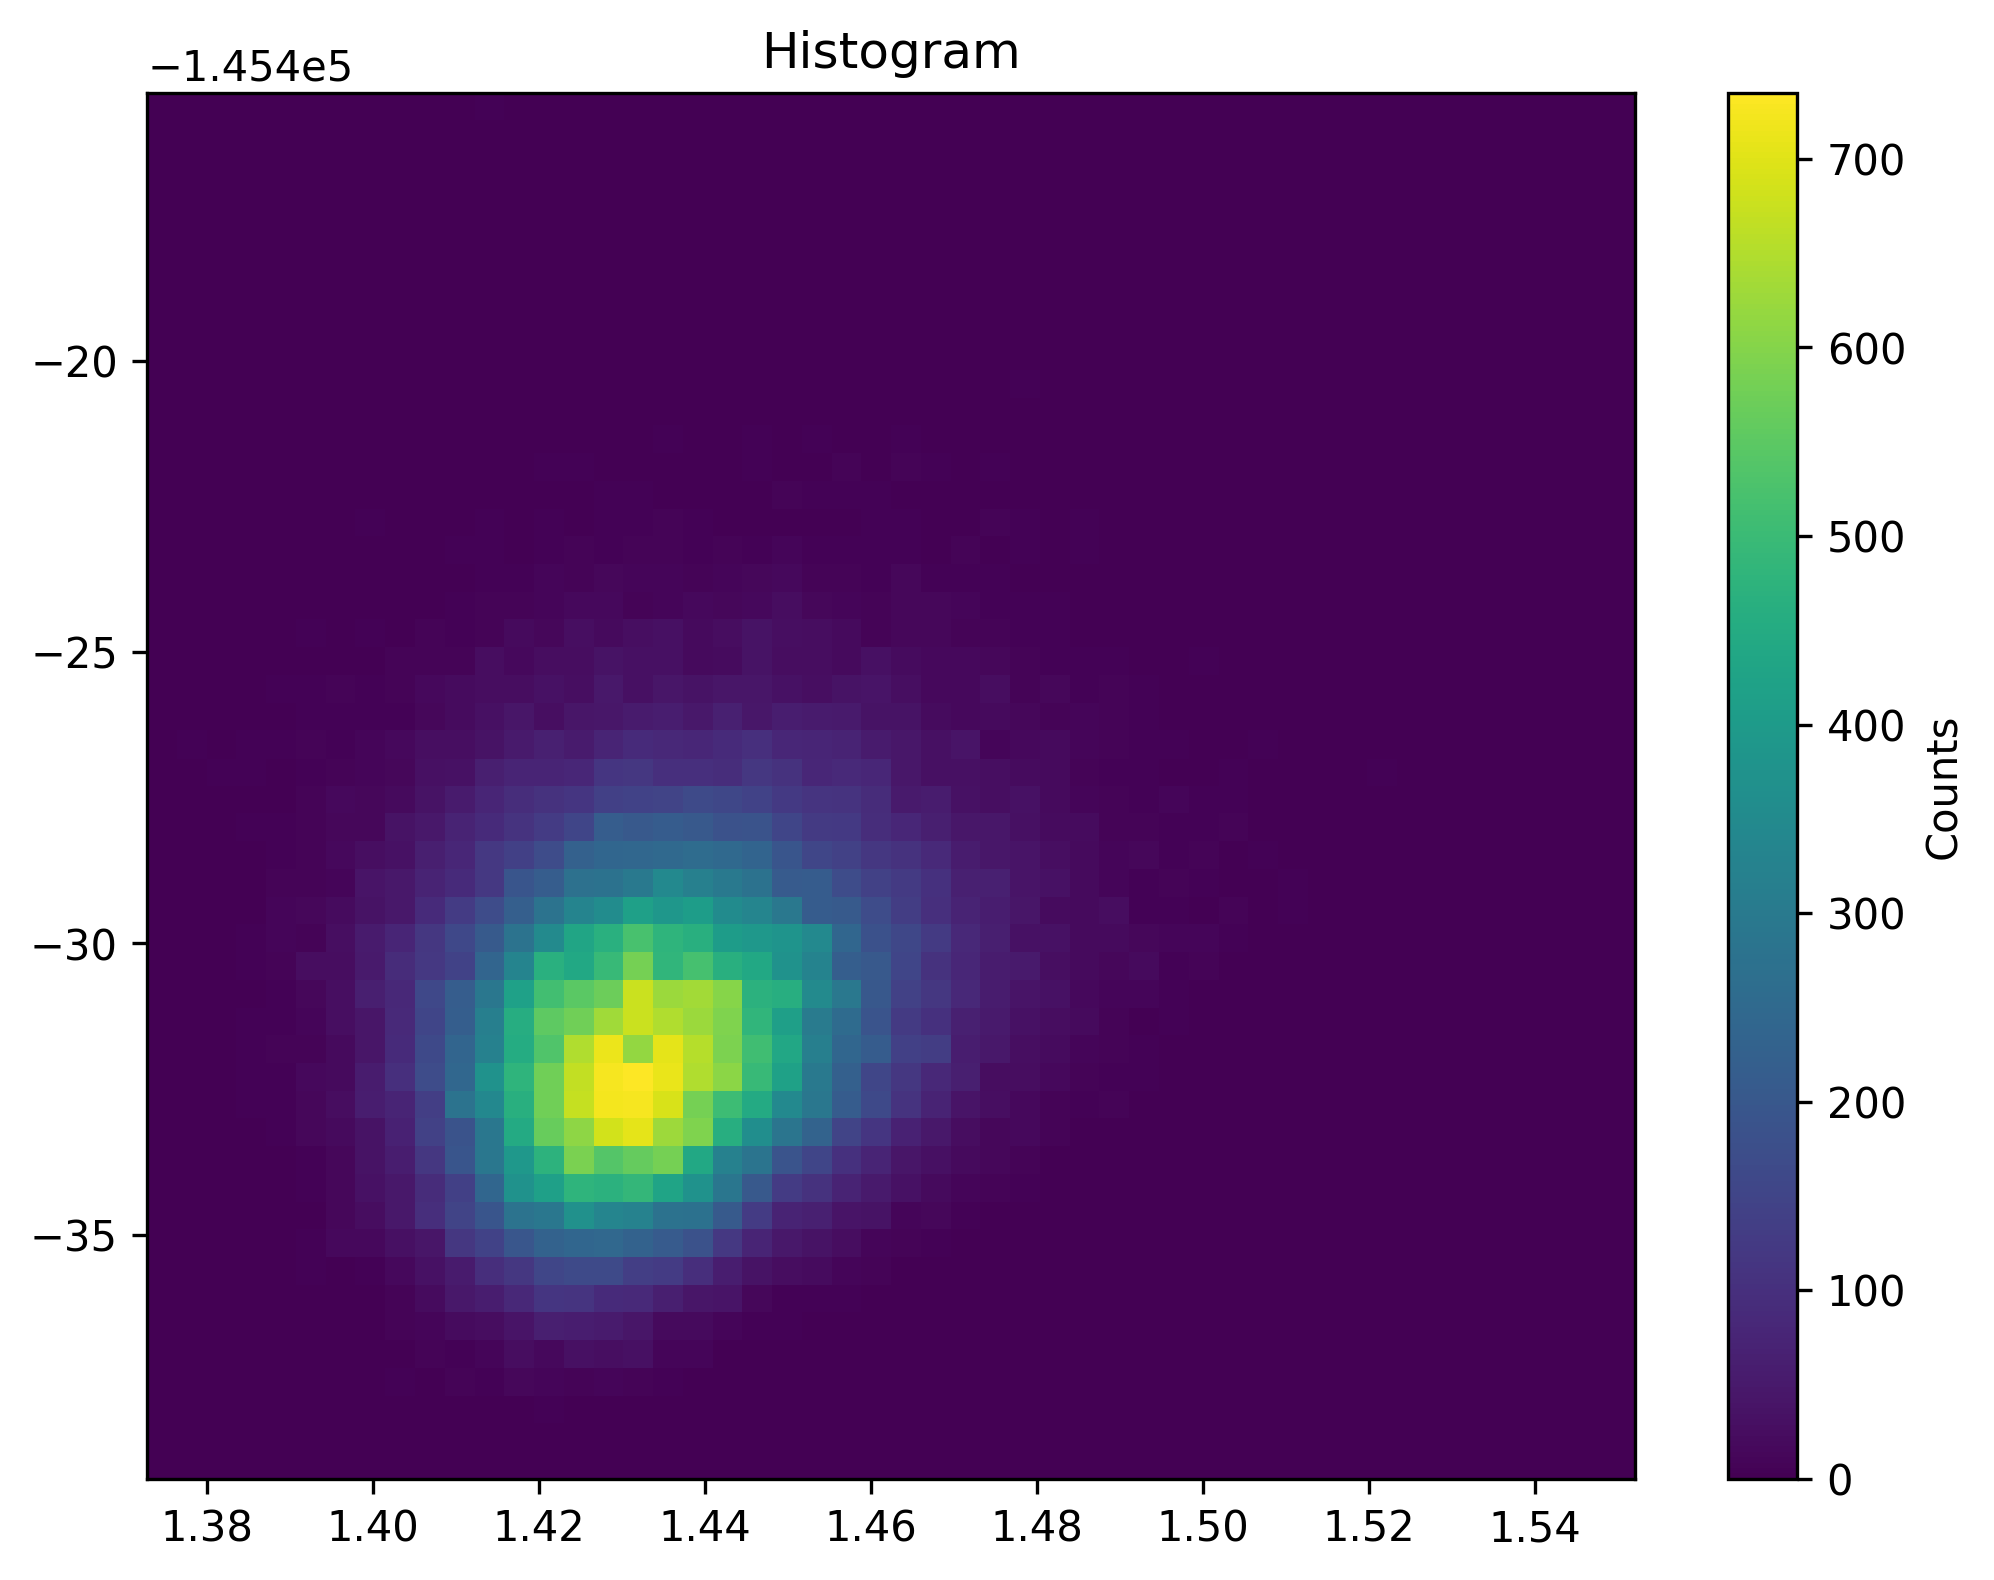

In [67]:
plot_2d_histograms(
    torch.max(calculate_bond_lengths_batched(positions), dim=1).values,
    energy
)

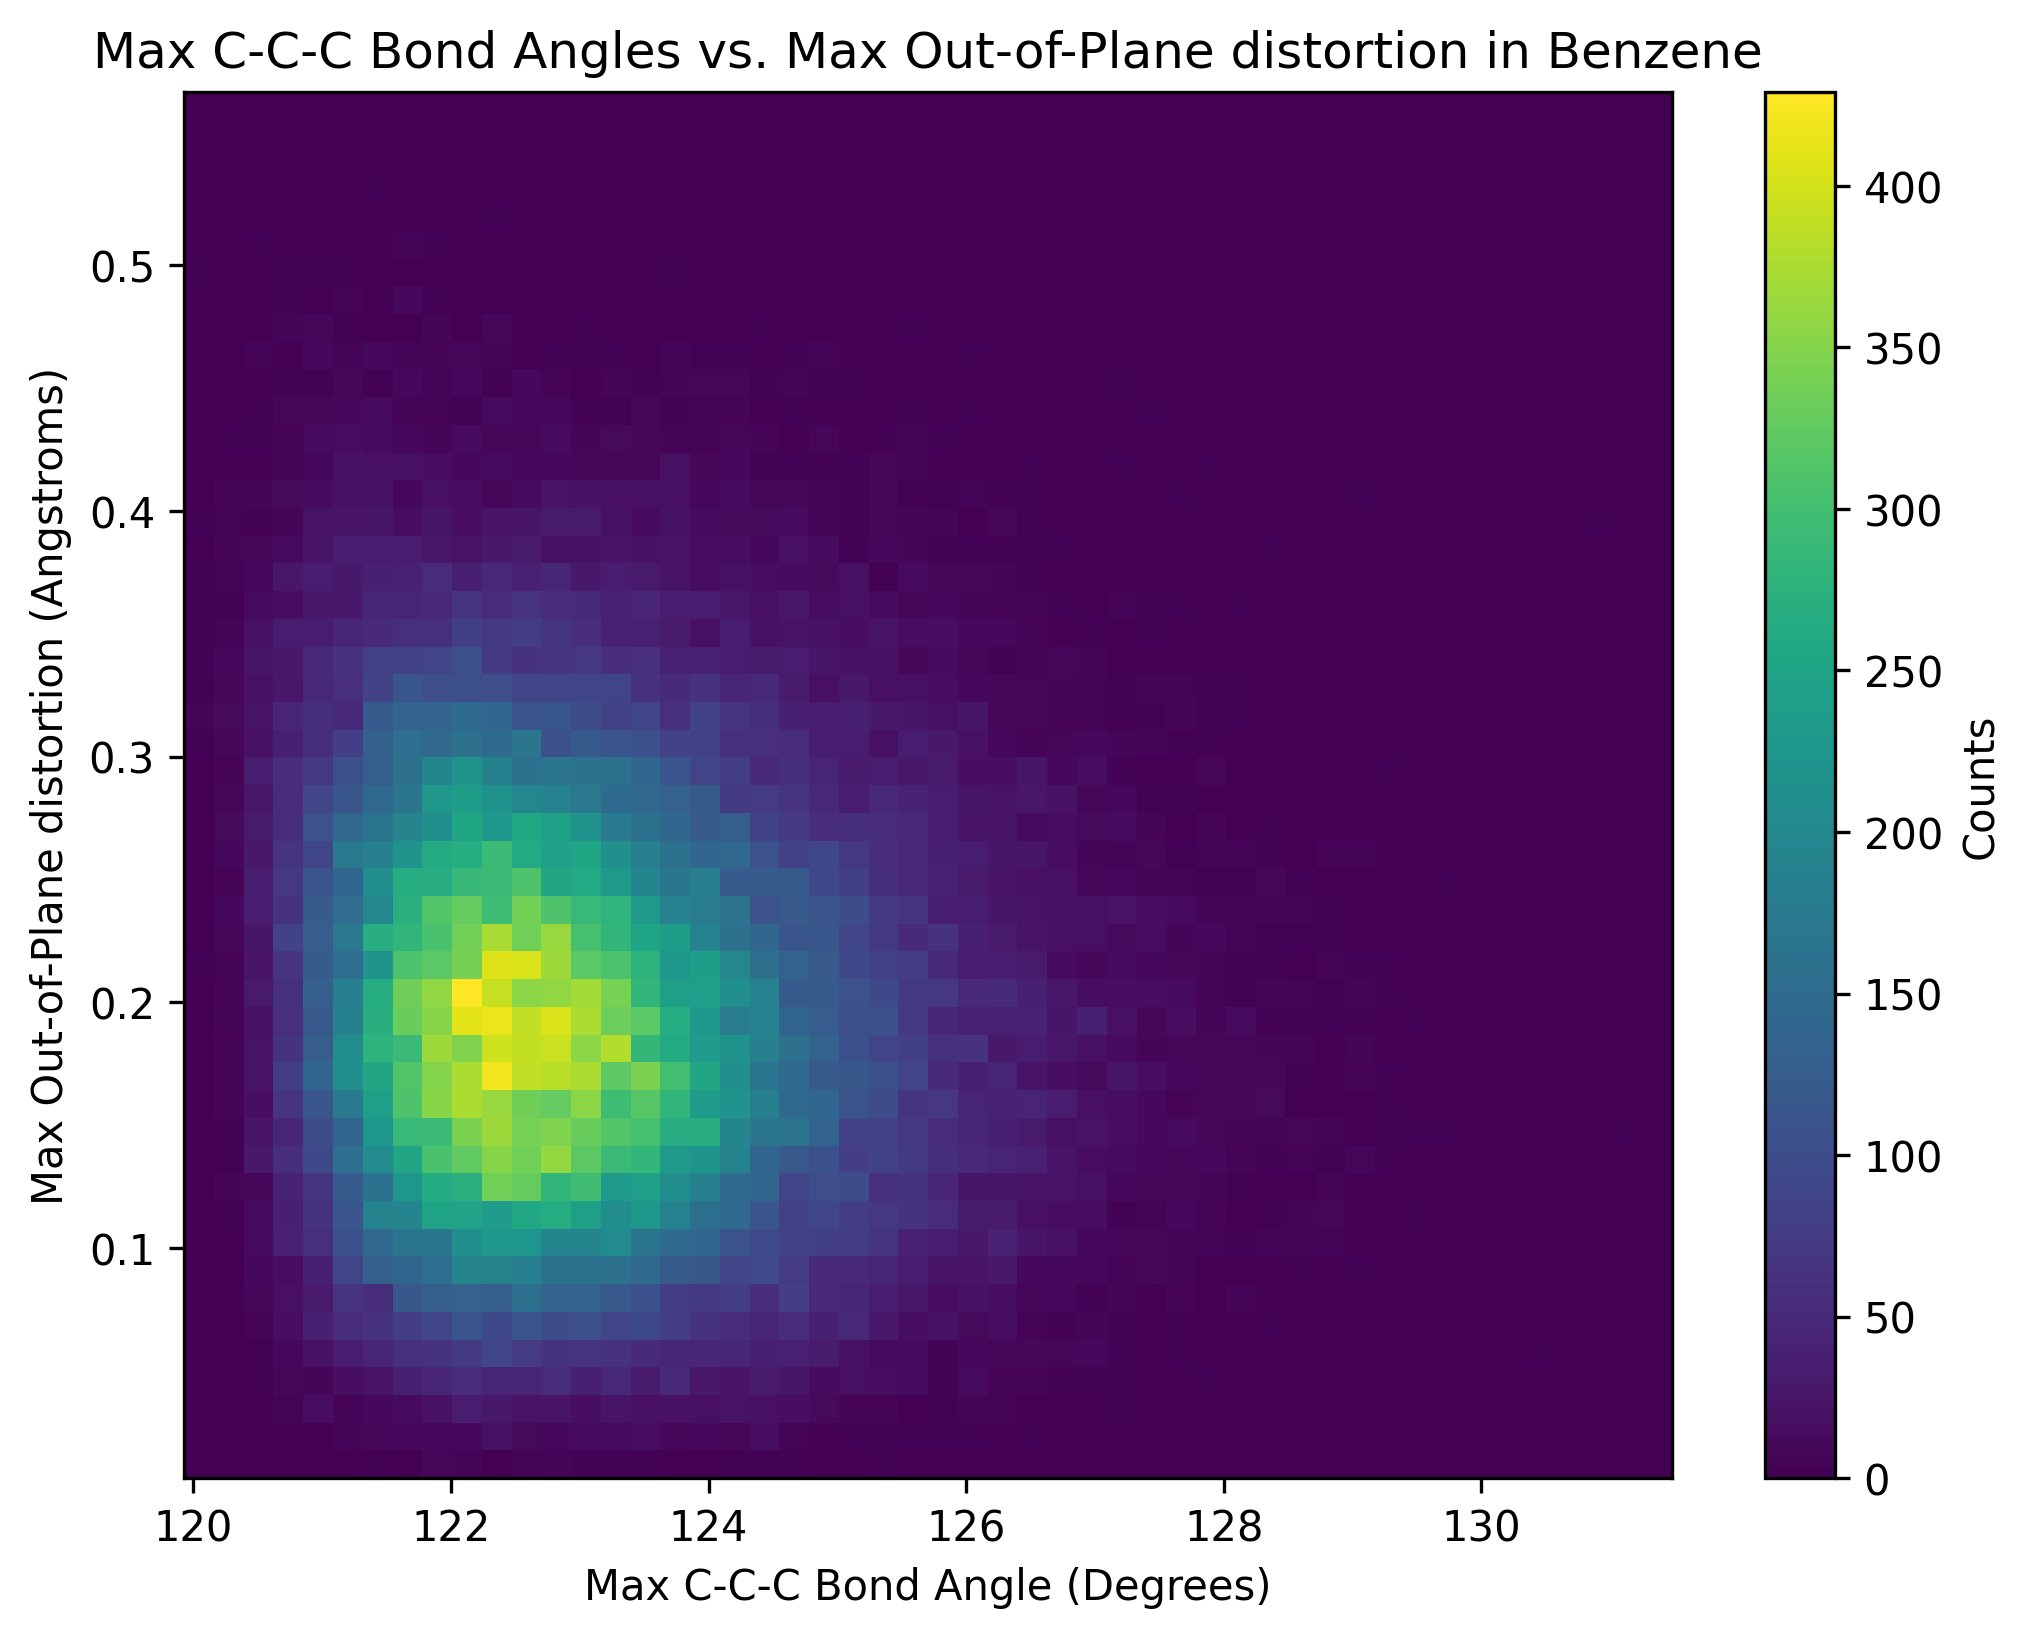

In [46]:
plot_bond_angles_and_oop_distortion(positions)

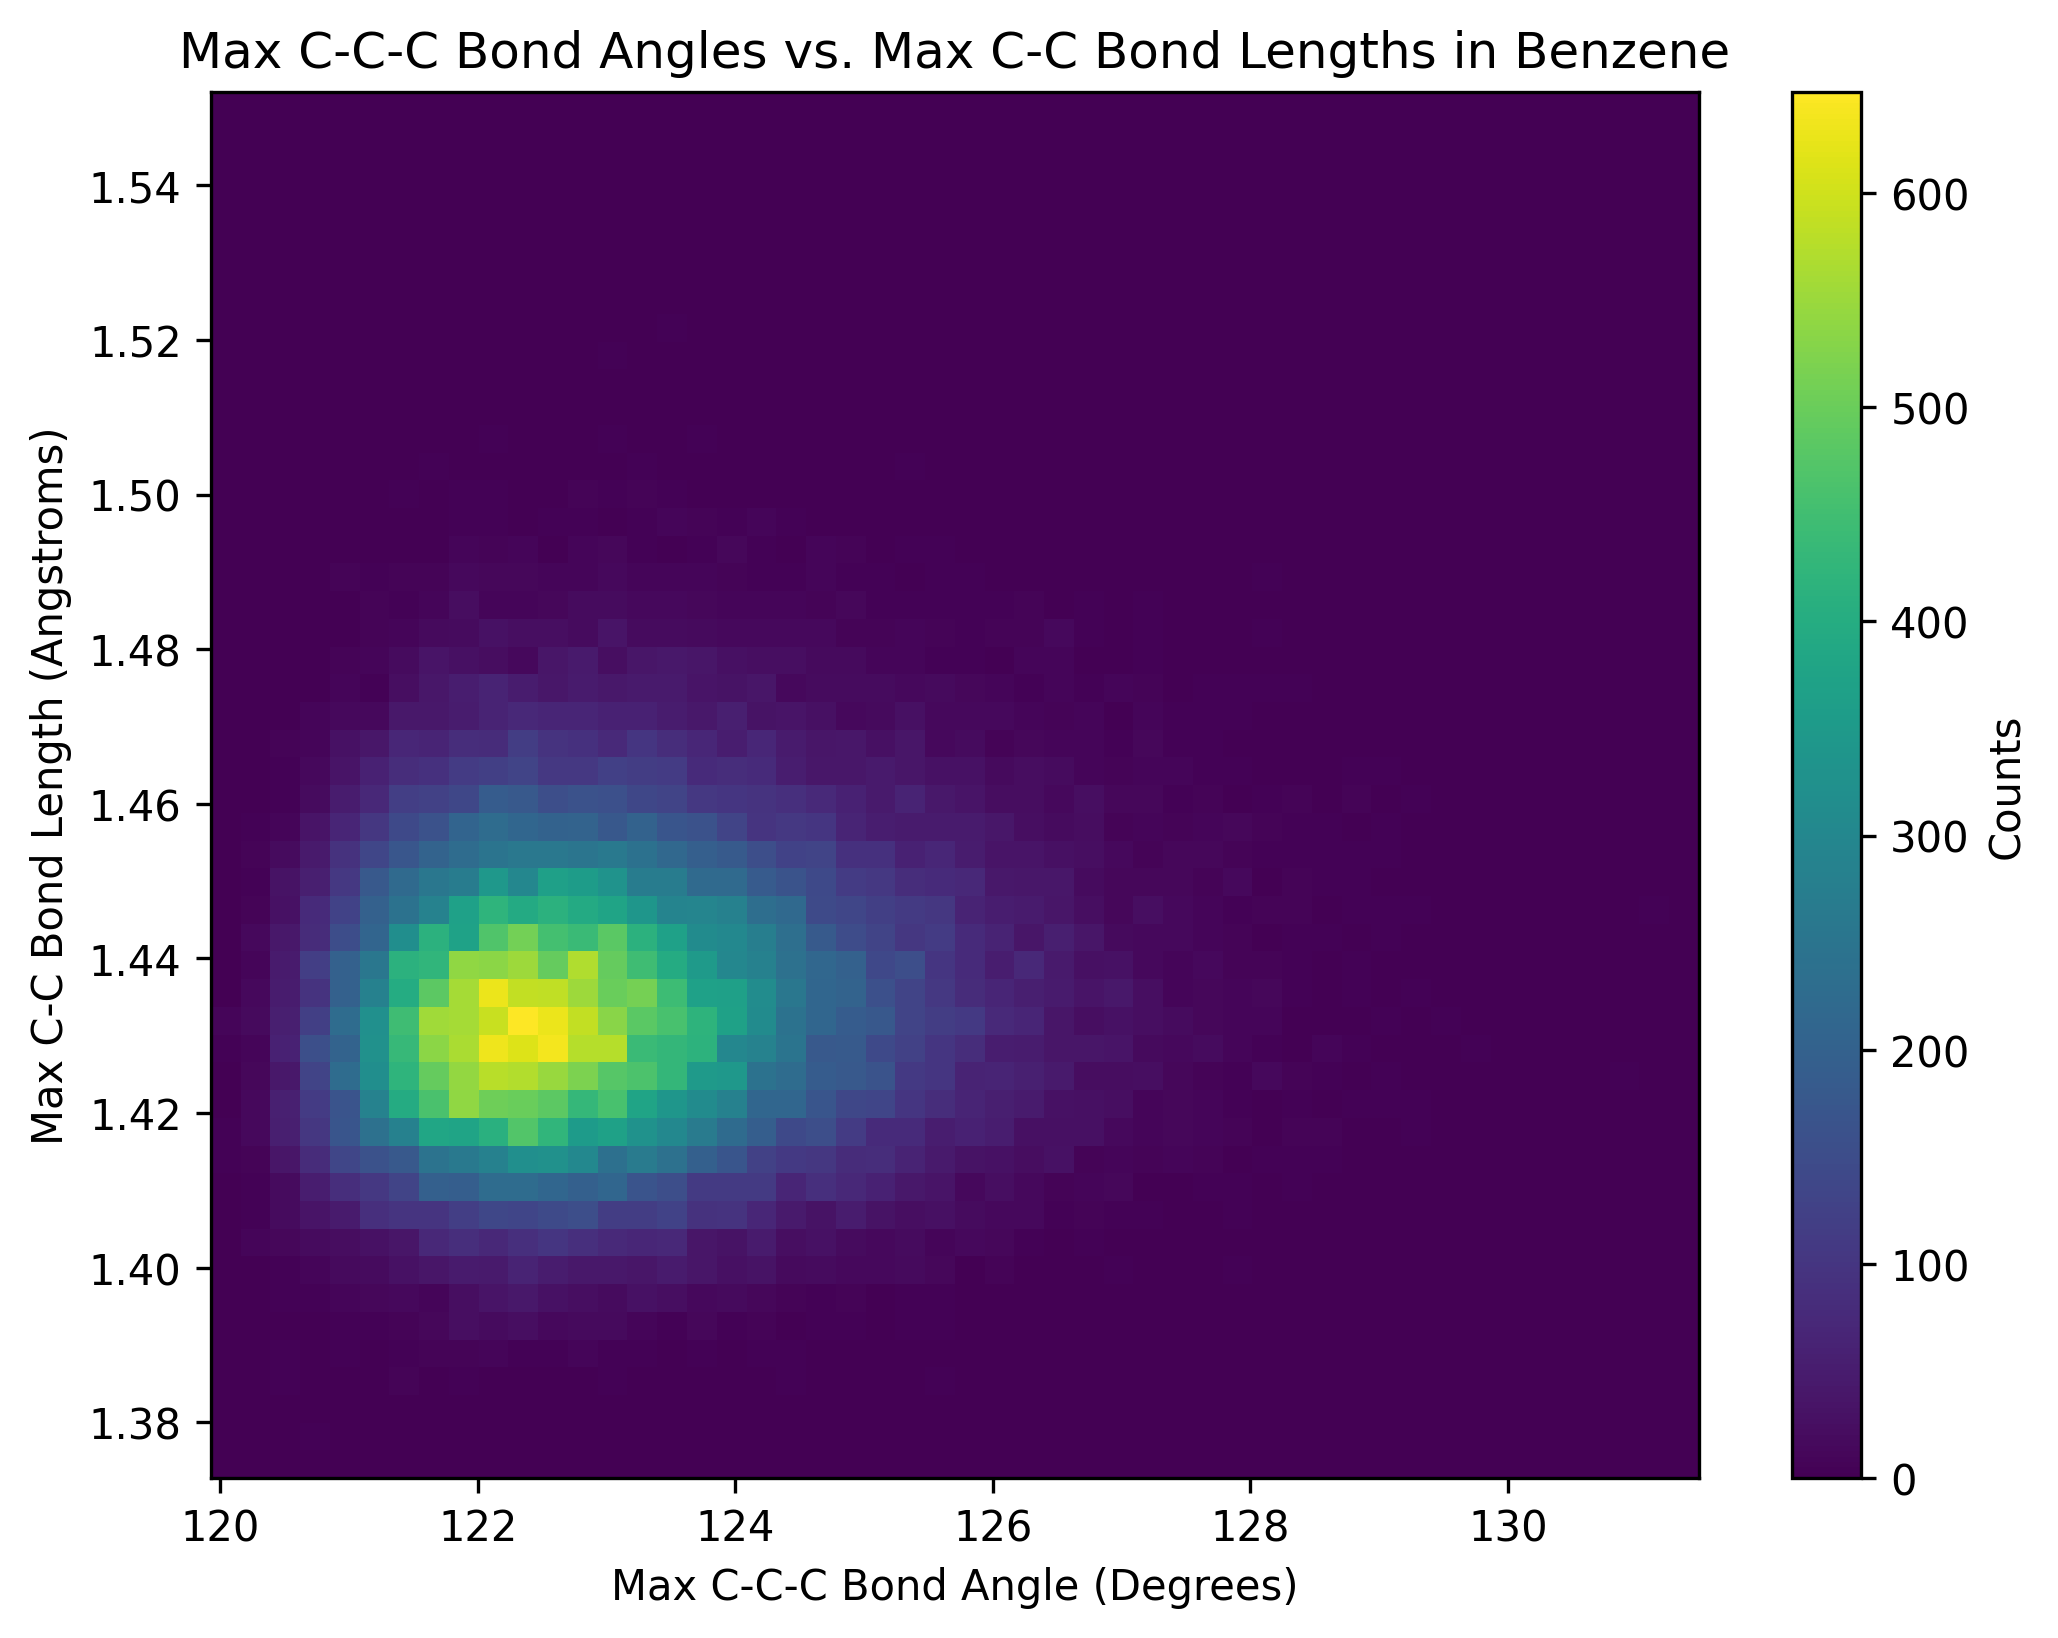

In [41]:
plot_bond_lengths_and_angles(positions)